# Learn Jax The Way That Makes Sense To Nobody Else

The intention behind this is to get comfortable with Jax up to the point of writing kernels in Pallas. A reasonable showcase of this would be implementation of newer models, the Transformer alternatives, i.e. Based and Griffin.

### Longer Term Goals

- train a model with pallas kernel on a tpu pod or H100. Make sure flops and bandwidth usage is gooood.
- track experiments with wandb

Why not PyTorch?  A few reasons:

- I already know PyTorch well. So this would be kinda boring if I used that.
- Jax has really powerful primitives and is built with a compiler in mind. Talk smack about Google all you want but they ship really incredible ML compiler software: XLA!
- It's used for more than cookie cutter ML. PyTorch is having a moment because 1) Huggingface transformers library, and 2) Transformers are good for everything apparently. But I believe Jax is a better piece of software.
- Deployment. The story here hasn't been great for Jax so far. But honestly, it's not good for PyTorch either, you have a sacrifice a chicken to compile something to mobile. GGML renders all of this obsolete anyway since you can just convert the weight to gguf format and go from there.
- Seems once you know what you're doing scaling it across multiple devices, pods, and clusters is a lot easier.
- Can take advantage of TPUs for training. That's NVIDIA's competition, not AMD. I honestly think this is quite a big flop from Google. Sell these to people FFS! Unless you know, competitive advantage, and yada yada yada :-)

I would like to use Julia for all of this but although SciML has taken off, ~Sci~ML not so much. It's really difficult to compete with MANGA, especially when all the models boil down to a few performant kernels.

In an alternative world, Chris Lattner would have used Julia instead of Swift while at Google, it would have intiated cash flow into the ecosystem from up the tech lords for ML development, and we would live in a utopia. Alas, we don't live there. We live in the world we he's trying to find his Mojo. Paging Dr. Evil.

In [6]:
import jax
from jax.experimental import pallas as pl
import jax.numpy as jnp
import numpy as np
from jax import random

In [11]:
x = jnp.ones((512, 512))

In [22]:
jnp.int4

jax.numpy.int4

In [ ]:
jnp.float8

In [34]:
# to get a random value we need to use a key
key = random.PRNGKey(452)
y = random.normal(key, (512, 512), jnp.bfloat16)
y

Array([[0.0441895, -0.769531, -1.25781, ..., 0.65625, -2.89062,
        -0.644531],
       [0.302734, 0.242188, -0.292969, ..., -0.71875, 1.54688, 0.429688],
       [-1.74219, 2.03125, 0.835938, ..., -0.742188, -0.71875, 0.283203],
       ...,
       [-2.89062, -0.152344, -0.132812, ..., 0.472656, 0.0245361, -1],
       [0.00488281, -0.0539551, -0.460938, ..., 0.5625, 0.0441895,
        0.894531],
       [-1.03125, 1.375, 1.61719, ..., -0.621094, -0.112793, -1.58594]],      dtype=bfloat16)

In [35]:
z = random.normal(key, (512, 512), jnp.bfloat16)
z

Array([[0.0441895, -0.769531, -1.25781, ..., 0.65625, -2.89062,
        -0.644531],
       [0.302734, 0.242188, -0.292969, ..., -0.71875, 1.54688, 0.429688],
       [-1.74219, 2.03125, 0.835938, ..., -0.742188, -0.71875, 0.283203],
       ...,
       [-2.89062, -0.152344, -0.132812, ..., 0.472656, 0.0245361, -1],
       [0.00488281, -0.0539551, -0.460938, ..., 0.5625, 0.0441895,
        0.894531],
       [-1.03125, 1.375, 1.61719, ..., -0.621094, -0.112793, -1.58594]],      dtype=bfloat16)

In [36]:
jnp.array_equal(y, z)

Array(True, dtype=bool)

That's no good. In JAX we can't reuse a key, we always need to use a new key.

In [37]:
key1, key2 = random.split(key)

In [38]:
key1

Array([1491820686, 1009696691], dtype=uint32)

In [41]:
z = random.normal(key1, (512, 512), jnp.bfloat16)
z

Array([[0.429688, 2.03125, -0.878906, ..., 1.01562, -0.112793, 0.242188],
       [0.5625, -1.25781, 1.78125, ..., 1.28125, -0.273438, 0.585938],
       [-1.10156, 1.05469, -0.3125, ..., 1.24219, -0.132812, 2.51562],
       ...,
       [-1.03125, -0.9375, -0.644531, ..., 0.451172, -0.644531, 0.925781],
       [-0.292969, 0.65625, -0.0147095, ..., 1.24219, 1.24219, 1.125],
       [0.451172, 0.539062, 2.51562, ..., -2.10938, 0.283203, 1.61719]],      dtype=bfloat16)

Different values! By the way you can create as many keys as you want.

In [44]:
random.split(key1, num=10)

Array([[2715293149, 1869756952],
       [2143116086, 4269846209],
       [1700306076,  306031570],
       [2972788532, 1569919732],
       [1165125172, 1774103344],
       [4154028601,  514593784],
       [1156115218, 2105534922],
       [2279146592,  105068904],
       [4030971763, 1734275684],
       [2539788112,  255303479]], dtype=uint32)

Ok. I'm wondering why we wouldn't just use random.PRNGKey over and over. Well there are 2 main reasons I can see.

1. PRGNKey creates 1 key, split creates as many as we need.
2. Reproducibility: the randomness of the entire program is initiated by a single seed. We'll get the same values everytime.

In [45]:
jnp.array_equal(random.split(key1, num=10), random.split(key1, num=10))

Array(True, dtype=bool)

We get the same keys!

There's two other ones I need to wrap my head around - vmap and grad.

vmap is a vectorized map. Really it's just a map but the term vectorized is used in array programming. Doing things one element at a time is really, really, really bad in array programming world because it uses hardware in the least effective way.

The alternative to vectorization is a for loop(s). Now for loops aren't actually bad. It's the implementation that's bad. You can make for loops really efficient such that they utilize hardware [incredibly well.](https://github.com/JuliaSIMD/LoopVectorization.jl?tab=readme-ov-file#matrix-multiply).

In fact vectorization, depending on the hardware can really just be a loop, it's just a heavily optimized one. So when someone says "use vectorization" I believe a good way to think about is "use the really optimized for loop routine".

In a language like Python it's particularly bad because it means using a Python for loop instead of a C++ heavily optimized array structure specialiazed for loop.

In any case that's a bit of a tangent because in JAX vmap is semantically much more meaningful. In allows us to not think about batches. Basically we can think of our model as operating on a single example the entire time, slap a vmap on top of that, and everything just works for batches of examples.

Compiler optimizations + DevUX = fire emoji

How does this work?

matmul is an easy enough example.

mk x kn matrices

but mk is bmk because it's batched.

In [66]:
key = random.PRNGKey(0)

weights = random.normal(key, (10, 50))
key1, key2 = random.split(key)
input = random.normal(key1, (20, 10))

f = lambda x: x @ weights
   
z = f(input)
print(z.shape)

(20, 50)


In [69]:
vf = jax.vmap(f, in_axes=0)

X = random.normal(key2, (100, 20, 10))

Z = vf(X)
print(Z.shape)

(100, 20, 50)


Super simplified but it gets across the fundamental use of vmap. Naturally allows us to turn a regular matmul to a batched one.

Batched matmul is perhaps the most common workload in deep learning so naturally JAX supports this out of the box.

In [71]:
(X @ weights).shape

(100, 20, 50)

## grad

this is straightforward, it's just a way to get the gradient. The use case I'm interested in is how to apply this to changing parameters. After all, JAX comes from a functional programming (pure) school of thought.

In [92]:
def f(x):
    return 3 * x**4 + 2 * x**3 + x**2 + 1

def df(x):
    return 12 * x**3 + 6 * x**2 + 2 * x**1

gf = jax.grad(lambda x: jnp.sum(f(x)))
x = jnp.arange(5, dtype=jnp.float32)
print(x)
print(f(x))
print(df(x))
print(gf(x))

[0. 1. 2. 3. 4.]
[  1.   7.  69. 307. 913.]
[  0.  20. 124. 384. 872.]
[  0.  20. 124. 384. 872.]


You can apply grad as much as you want. JAX is different from other frameworks in that it optimizes higher derivatives really well.

In [95]:
from jax import grad

In [103]:
ggf = grad(grad(f))
gggf = grad(ggf)
ggggf = grad(gggf)
gggggf = grad(ggggf)

print(ggf(1.0))
print(gggf(1.0))
print(ggggf(1.0))
print(gggggf(1.))

50.0
84.0
72.0
0.0


eventually we're left with a constant where the gradients is 0

Let's implement linear regression with all we know so far.

Let's say each example is 10 features and we're predicting some value with noise

In [192]:
# Set random seed for reproducibility
key = random.PRNGKey(0)

# Define the number of examples and features
num_examples = 1000
num_features = 10

# Generate random feature values
key, subkey = random.split(key)
X = random.normal(subkey, (num_examples, num_features))

# Generate random coefficients for the linear relationship
key, subkey = random.split(key)
true_coefficients = random.normal(subkey, (num_features,))

# Generate random noise
key, subkey = random.split(key)
noise = random.normal(subkey, (num_examples,)) * 0.2

# Calculate the target values
y = jnp.dot(X, true_coefficients) + noise

In [193]:
key, subkey1, subkey2 = random.split(key, num=3)
W1 = jax.nn.initializers.xavier_normal()(subkey1, (10, 768))
b1 = jnp.zeros(768)
W2 = jax.nn.initializers.xavier_normal()(subkey2, (768, 1))
b2 = jnp.zeros(1)

In [242]:
def model(x, W1, b1, W2, b2):
    # the model is a 2 layer neural net with a gelu activation
    return jax.nn.relu(x @ W1 + b1) @ W2 + b2
    
def loss(x, W1, b1, W2, b2, y):
    return jnp.mean(jnp.square(model(x, W1, b1, W2, b2) - y))

In [195]:
model(X[1, :], W1, b1, W2, b2)

Array([0.], dtype=float32)

In [196]:
loss(X[1, :], W1, b1, W2, b2, y)

Array(9.288742, dtype=float32)

In [197]:
gloss = grad(loss, argnums=(1,))

In [198]:
ret = gloss(X[1, :], W1, b1, W2, b2, y)
assert len(ret) == 1 # should be only for W1
assert ret[0].shape == (10, 768)

ok let's update the weights now

In [199]:
gloss = jax.value_and_grad(loss, argnums=(1, 2, 3, 4))

@jax.jit
def update(x, y, W1, W2, b1, b2, step_size=5e-4):
    v, grads = gloss(x, W1, b1, W2, b2, y)
    return (v, [grads[0] * step_size, grads[1] * step_size, grads[2] * step_size, grads[3] * step_size])

In [200]:
v, grads = gloss(X[1, :], W1, b1, W2, b2, y)
print(v)
print(len(grads))
for g in grads:
    print(g.shape)

9.288742
4
(10, 768)
(768,)
(768, 1)
(1,)


This might not actually work so let's but it in a single block so we can iterate quicker.

Notes

- using a 2 layer network like this is overkill. We can get the same result with a 1 layer 10 dim one.
- JAX grad updates are tricky, we're better off just using optax. You cannot mutate the current parameters so you need to return the new parameters in the update function. In PyTorch you would just do `+=` but in JAX this does not do what you want. The good news is that JAX optimizes away the extra memory this would normally incur.|

In [243]:
import optax

# Set random seed for reproducibility
key = random.PRNGKey(0)
# Define the number of examples and features
num_examples = 1000
num_features = 10
# Generate random feature values
key, subkey = random.split(key)
X = random.normal(subkey, (num_examples, num_features))
# Generate random coefficients for the linear relationship
key, subkey = random.split(key)
true_coefficients = random.normal(subkey, (num_features,))
# Generate random noise
key, subkey = random.split(key)
noise = random.normal(subkey, (num_examples,)) * 0.2
# Calculate the target values
y = jnp.dot(X, true_coefficients) + noise

key, subkey1, subkey2 = random.split(key, num=3)
W1 = jax.nn.initializers.xavier_normal()(subkey1, (10, 768))
b1 = jnp.zeros(768)
W2 = jax.nn.initializers.xavier_normal()(subkey2, (768, 1))
b2 = jnp.zeros(1)

def model(x, W1, b1, W2, b2):
    # the model is a 3 layer neural net with a relu activation
    h1 = jax.nn.gelu(x @ W1 + b1)
    h2 = h1 @ W2 + b2
    return jnp.squeeze(h2)
    
def loss(x, W1, b1, W2, b2, y):
    return jnp.mean(jnp.square(model(x, W1, b1, W2, b2) - y))

gloss = jax.value_and_grad(loss, argnums=(1, 2, 3, 4))
    
optimizer = optax.adam(learning_rate=6e-3)
opt_state = optimizer.init((W1, b1, W2, b2))

@jax.jit
def update(x, y, params, opt_state):
    (W1, b1, W2, b2) = params
    v, grads = gloss(x, W1, b1, W2, b2, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return v, params, opt_state

num_epochs = 1000
batch_size = 128
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = train['x'].shape[0] // batch_size
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        x_batch = train['x'][batch_start:batch_end]
        y_batch = train['y'][batch_start:batch_end]
        
        l, (W1, b1, W2, b2), opt_state = update(x_batch, y_batch, (W1, b1, W2, b2), opt_state)
        
        epoch_loss += l
    
    epoch_loss /= num_batches
    print(f"Epoch {epoch+1}, Loss = {epoch_loss}")

Epoch 1, Loss = 4.312105178833008
Epoch 2, Loss = 0.6103231310844421
Epoch 3, Loss = 0.36601418256759644
Epoch 4, Loss = 0.1853693574666977
Epoch 5, Loss = 0.12574252486228943
Epoch 6, Loss = 0.07538404315710068
Epoch 7, Loss = 0.05615144968032837
Epoch 8, Loss = 0.048834215849637985
Epoch 9, Loss = 0.04314957186579704
Epoch 10, Loss = 0.04271193966269493
Epoch 11, Loss = 0.04071473330259323
Epoch 12, Loss = 0.03981667384505272
Epoch 13, Loss = 0.03976481407880783
Epoch 14, Loss = 0.03946791589260101
Epoch 15, Loss = 0.03947140648961067
Epoch 16, Loss = 0.039213377982378006
Epoch 17, Loss = 0.0393802635371685
Epoch 18, Loss = 0.039138130843639374
Epoch 19, Loss = 0.03925147280097008
Epoch 20, Loss = 0.039147090166807175
Epoch 21, Loss = 0.03918766975402832
Epoch 22, Loss = 0.03913630172610283
Epoch 23, Loss = 0.03917775675654411
Epoch 24, Loss = 0.03913819417357445
Epoch 25, Loss = 0.039169322699308395
Epoch 26, Loss = 0.03916751220822334
Epoch 27, Loss = 0.039173681288957596
Epoch 28,

Epoch 229, Loss = 0.03577738627791405
Epoch 230, Loss = 0.0357036292552948
Epoch 231, Loss = 0.03563045337796211
Epoch 232, Loss = 0.03555775433778763
Epoch 233, Loss = 0.0354854017496109
Epoch 234, Loss = 0.03541328012943268
Epoch 235, Loss = 0.03534131124615669
Epoch 236, Loss = 0.03526937961578369
Epoch 237, Loss = 0.03519744798541069
Epoch 238, Loss = 0.03512544184923172
Epoch 239, Loss = 0.0350533127784729
Epoch 240, Loss = 0.034981079399585724
Epoch 241, Loss = 0.034908708184957504
Epoch 242, Loss = 0.034836217761039734
Epoch 243, Loss = 0.034763630479574203
Epoch 244, Loss = 0.0346909835934639
Epoch 245, Loss = 0.034618303179740906
Epoch 246, Loss = 0.03454564884305
Epoch 247, Loss = 0.03447306901216507
Epoch 248, Loss = 0.0344005785882473
Epoch 249, Loss = 0.03432823717594147
Epoch 250, Loss = 0.034256063401699066
Epoch 251, Loss = 0.03418406471610069
Epoch 252, Loss = 0.03411223739385605
Epoch 253, Loss = 0.03404054790735245
Epoch 254, Loss = 0.03396895155310631
Epoch 255, Los

Epoch 471, Loss = 0.02771701291203499
Epoch 472, Loss = 0.027414565905928612
Epoch 473, Loss = 0.025545023381710052
Epoch 474, Loss = 0.023636000230908394
Epoch 475, Loss = 0.02243347279727459
Epoch 476, Loss = 0.02153441496193409
Epoch 477, Loss = 0.02180306799709797
Epoch 478, Loss = 0.02202639728784561
Epoch 479, Loss = 0.020866634324193
Epoch 480, Loss = 0.02009332925081253
Epoch 481, Loss = 0.019617266952991486
Epoch 482, Loss = 0.019536729902029037
Epoch 483, Loss = 0.019309593364596367
Epoch 484, Loss = 0.0188859011977911
Epoch 485, Loss = 0.01912548765540123
Epoch 486, Loss = 0.01873999647796154
Epoch 487, Loss = 0.01859765127301216
Epoch 488, Loss = 0.018302196636795998
Epoch 489, Loss = 0.01839575171470642
Epoch 490, Loss = 0.01851428858935833
Epoch 491, Loss = 0.01813756301999092
Epoch 492, Loss = 0.018083849921822548
Epoch 493, Loss = 0.01768401265144348
Epoch 494, Loss = 0.017970528453588486
Epoch 495, Loss = 0.017932720482349396
Epoch 496, Loss = 0.017800381407141685
Epoc

Epoch 692, Loss = 0.010891770012676716
Epoch 693, Loss = 0.011140248738229275
Epoch 694, Loss = 0.011400970630347729
Epoch 695, Loss = 0.011724679730832577
Epoch 696, Loss = 0.011916178278625011
Epoch 697, Loss = 0.011878584511578083
Epoch 698, Loss = 0.011827979236841202
Epoch 699, Loss = 0.011935601010918617
Epoch 700, Loss = 0.012223836034536362
Epoch 701, Loss = 0.012838834896683693
Epoch 702, Loss = 0.013875204138457775
Epoch 703, Loss = 0.014913935214281082
Epoch 704, Loss = 0.01540822722017765
Epoch 705, Loss = 0.015217401087284088
Epoch 706, Loss = 0.014728691428899765
Epoch 707, Loss = 0.014609546400606632
Epoch 708, Loss = 0.015118062496185303
Epoch 709, Loss = 0.01588384062051773
Epoch 710, Loss = 0.016250427812337875
Epoch 711, Loss = 0.01571544073522091
Epoch 712, Loss = 0.014692397788167
Epoch 713, Loss = 0.014342703856527805
Epoch 714, Loss = 0.014613546431064606
Epoch 715, Loss = 0.014558227732777596
Epoch 716, Loss = 0.014029902406036854
Epoch 717, Loss = 0.01312336977

Epoch 932, Loss = 0.007214639335870743
Epoch 933, Loss = 0.007885962724685669
Epoch 934, Loss = 0.007142830640077591
Epoch 935, Loss = 0.007650845218449831
Epoch 936, Loss = 0.007643126416951418
Epoch 937, Loss = 0.007981493137776852
Epoch 938, Loss = 0.007540537044405937
Epoch 939, Loss = 0.007803563494235277
Epoch 940, Loss = 0.00831476878374815
Epoch 941, Loss = 0.007777410093694925
Epoch 942, Loss = 0.00825024489313364
Epoch 943, Loss = 0.007827944122254848
Epoch 944, Loss = 0.008837807923555374
Epoch 945, Loss = 0.007697024382650852
Epoch 946, Loss = 0.008631201460957527
Epoch 947, Loss = 0.00812570471316576
Epoch 948, Loss = 0.008543359115719795
Epoch 949, Loss = 0.008352862671017647
Epoch 950, Loss = 0.00810808502137661
Epoch 951, Loss = 0.008793339133262634
Epoch 952, Loss = 0.008053544908761978
Epoch 953, Loss = 0.008824418298900127
Epoch 954, Loss = 0.008105548098683357
Epoch 955, Loss = 0.008967215195298195
Epoch 956, Loss = 0.008826855570077896
Epoch 957, Loss = 0.008766939

what else should we cover for preliminary purposes? maybe pmap? That's a multi device thing so perhaps not yet.

going forward we'll use flax for composing models together since we're trying to reinvent the wheel here. It simplifies a lot of this process.

for data loading tfds is typically used but I really don't want to deal with TensorFlow. Huggingface datasets is really easy to use, so let's try to use that.

In [245]:
from flax import linen as nn

In [248]:
jax.ShapeDtypeStruct

jax._src.api.ShapeDtypeStruct

I'm going to disgress a bit here and go into attention implementations. Attention is the core building block of Transformer model and likely all token based models going forward unless something changes drastically. And more and more models are becoming token based models.

Attention is, simply, in simplistic layman's terms, the matter of determining which generated tokens are important for prediction of the next token.

What this looks like in practice is a heatmap of a lower triangular matrix

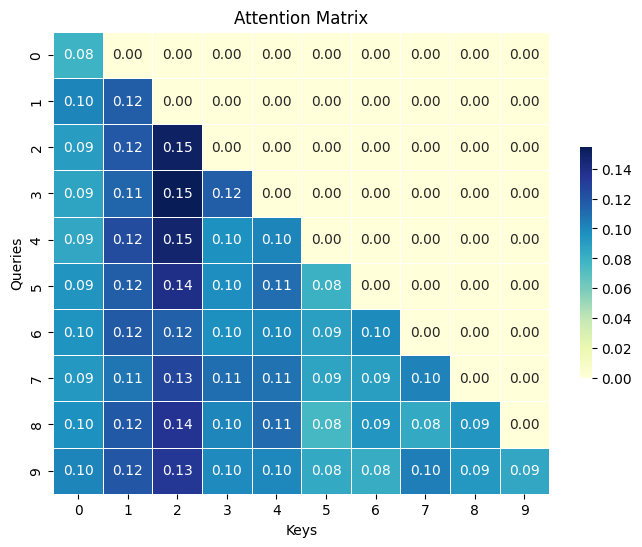

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

seq_len = 10
head_dim = 32
Q = np.random.rand(seq_len, head_dim)
K = np.random.rand(seq_len, head_dim)
attn = jnp.tril(jax.nn.softmax((Q @ K.T) / jnp.sqrt(head_dim)))

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(attn, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Set title and labels
plt.title("Attention Matrix")
plt.xlabel("Keys")
plt.ylabel("Queries")

# Show the plot
plt.show()

The simplest attention kernel is softmax(Q*K^T / sqrt(d)) * V 

In [ ]:
def casual_attention(x, Q, K, V, mask):
    """
    x is the input tensor of shape (seq_len, dim)
    Q, K, V are the weight matrices of shape (dim, dim)
    O is the output weight matrix of shape (dim, dim)
    mask is the mask tensor of shape (seq_len, seq_len)
    """
    q = x @ Q
    k = x @ K
    v = x @ V
    dim = jnp.array(x.shape[-1], dtype=jnp.float32)
    logits = jax.nn.softmax(((q @ k.T) / jnp.sqrt(dim)), where=mask, initial=0)
    return logits @ v, logits

key = jax.random.PRNGKey(0)
seq_len = 4
dim = 10
x = jax.random.normal(key, (seq_len, dim))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (dim, dim))
K = jax.random.normal(key2, (dim, dim))
V = jax.random.normal(key3, (dim, dim))
mask = jnp.tril(jnp.ones((seq_len, seq_len)))

output, attn = casual_attention(x, Q, K, V, mask)
print(output.shape)
print(attn.shape)



This is closer to an implementation of what you would actually find in the wild. What I really want you to pay attention to, pun intended, in the shape of q, k, and v.

it is (b, h, s, hd).

What does this mean?

We are using attention for every (b, h) pair. Assume b = 1. Each head has its own attention matrix. This is why it's called multi-head attention. Now, potentially each head learns something different.

In [ ]:
def batched_casual_attention(x, Q, K, V, mask):
    """
    x is the input tensor of shape (b, s, d)
    Q, K, V are the weight matrices of shape (d, d)
    mask is the mask tensor of shape (b, h, s, s)
    the output is of shape(b, s, d)

    b is the batch size
    s is the sequence length
    d is the embedding dimension
    h is the number of heads

    each head gets its own attention matrix.
    """
    b,s,d = x.shape
    h = mask.shape[1]
    hd = d // h
    q = (x @ Q).reshape(b, h, s, hd)
    k = (x @ K).reshape(b, h, s, hd)
    v = (x @ V).reshape(b, h, s, hd)
    attn_m = jnp.einsum('bhqd, bhkd -> bhqk', q, k) / jnp.sqrt(hd)
    logits = jax.nn.softmax(attn_m, where=mask, initial=0)
    o = jnp.einsum('bhqk, bhvd -> bhqd', logits, v)
    ret =  jnp.einsum('bhqd->bqhd', o).reshape(b, s, d)
    return ret, logits


key = jax.random.PRNGKey(0)
bs = 2
sq = 4
dim = 32
heads = 8
x = jax.random.normal(key, (bs, sq, dim))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (dim, dim))
K = jax.random.normal(key2, (dim, dim))
V = jax.random.normal(key3, (dim, dim))
mask = jnp.tril(jnp.ones((bs, heads, sq, sq)))

output, attn = batched_casual_attention(x, Q, K, V, mask)
print(output.shape)
print(attn.shape)

Transformer models seem to be universally good base models. I believe this is because of two factors:

1. attention block
2. resnet passthrough mechanism

allow me explain 2) further. Prior to resnet, or perhaps u-net? Did u-net come out before resnet? anyway, resnet opularized it because they achieved state of the art performance on ImageNet. Yes, back when classfying 1000 classes was what all the cool kids were trying to do.

Resnet introduced this passthrough mechanism whereby one kept the output the previous layers by adding it, basically if you had a layer f, which takes input x, then the output if not just f(x), but f(x) + x. This subtle change allows backpropagation to alter x in a more direct manner, shown directly by the sheer numbers of layers resnet could use without gradient issues, yes gradient issues, those were also a thing. Vanishing gradients, exploding gradients, really those gradients were could a handful, nothing like the well behaved ones we see today.

Transformers keep this mechanism, but also add the attention block, which allows the network to learn how one part of the input affects all the others.

Interestingly, Transformer models we find now are simpler than the original, but these two components stay.

Now that we've come across this universal architecture, now we optimize it for actual use.

> a single layer neural network is a universal function approximator, if it is wide enough, but getting that to actually work in practice have panned out to well. Perhaps this is partly a hardware issue, since you can only fit so much into GPU memory, for the time being more, narrow layers are favoured over fewer, wider ones.

### Training

Use the GPU as much as possible. The speed at which a GPU can compute is >> than the speed at which it can load/read it into memory. Thus most of the work here is enabling that, and doing that at a massive scale. Over many accelerators.

### Inference

Inference is in many ways much more interesting, the input is far less constrained, and also this is the direct use case. If it can't infer quickly, then it's useless, nobody will want to use it. Much more the work for faster kernels directly transfer over to here as well. But there are also several inference optimizations we can make as well.



### Multi-Query Attention

https://arxiv.org/pdf/1911.02150.pdf

This paper introduces mutli-query attention, a variation of multi-head attention.

Ok, here's my problem. I see many articles about this online, but none of them explain why I should give a shit about MQA. This is problem with explanations in general, they came from the assumption you know why it's important. Maybe they don't even know why it's important. I just realized this is why Karpathy is such an excellent teacher. He explains why it's important, why _this_, and not _that_.

Ok.

So why is this important.

It comes down to this observation. An accelerator, like a GPU can do arithmetic operations orders of magnitude faster than it can process (read/write) data to memory. This means we want to constantly feed it data, such that there is gap where it is so fully utilizing the available compute.

In the context of training this is generally not a problem, since we give the accelerator the largest batch size it can fit.

- b - batch size
- s - sequence length
- e - embedding dimension
- h - numbers of heads
- d - head dimension = e / h

If we have two matrices A (s * d), and B (d * s), then the work for matrix multiplication is $O(s^2*d)$

Arithmetic operators are $O(b * h * s^2 * d) = O(b * e * s^2)$ + $O(b * s * e^2)$. Depending on whether $e$ or $s$ is larger, one of these is the dominant factor.

For inference, e >= s, is likely.



## Pallas ?

In [47]:
def add_matrices_kernel(x_vmem_ref, y_vmem_ref, z_vmem_ref):
  # Load x and y from VMEM into VREGs
  x_vregs = x_vmem_ref[:, :]
  y_vregs = y_vmem_ref[:, :]
  # Execute a vectorized add
  z_vregs = x_vregs + y_vregs
  # Store the output values in VREGs back into VMEM
  z_vmem_ref[:, :] = z_vregs


def add_matrices(x: jax.Array, y: jax.Array) -> jax.Array:
  # pallas_call will first allocate scratch buffers for `x` and `y` in VMEM.
  # It will then copy `x` and `y` from HBM into VMEM.
  z = pl.pallas_call(
      add_matrices_kernel, out_shape=jax.ShapeDtypeStruct(x.shape, x.dtype)
  )(x, y)
  # pallas_call will also copy the output from VMEM back into HBM.
  return z


x, y = jnp.ones((512, 512)), jnp.ones((512, 512))
add_matrices(x, y)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

In [48]:
x

Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [5]:
x.devices()

{cuda(id=0)}